In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model, Sequential



C:\Users\annek\AppData\Local\Temp\ipykernel_15720\4172943127.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file u00063s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    31
Name: timestamp, dtype: int32




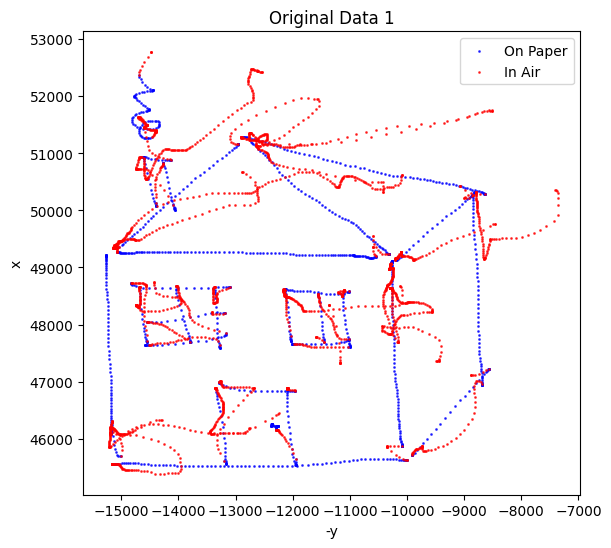

Processed data shape: (3423, 4)
Average number of data points: 3423


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=10)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [10]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Cell 3 (modified)
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = LSTM(64, return_sequences=True)
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.lstm(inputs)
        return self.dense(x)


# Function to compute loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss

latent_dim = 128
beta = 0.0001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [11]:
# Cell 4 (modified)
@tf.function
def train_step(vae, discriminator, x, optimizer, disc_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # VAE forward pass and loss calculation
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(vae, x)
        total_loss = reconstruction_loss + total_kl_loss

        # Generate data using VAE
        generated_data, _, _ = vae(x)
        real_labels = tf.ones((x.shape[0], 1))
        fake_labels = tf.zeros((x.shape[0], 1))

        # Discriminator forward pass and loss calculation
        disc_real_output = discriminator(tf.expand_dims(x, axis=1))
        disc_fake_output = discriminator(tf.expand_dims(generated_data, axis=1))
        disc_loss_real = tf.keras.losses.binary_crossentropy(real_labels, disc_real_output)
        disc_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, disc_fake_output)
        disc_loss = 0.5 * tf.reduce_mean(disc_loss_real + disc_loss_fake)

        # Adversarial loss (with a small factor to minimize effect)
        adv_loss = 0.001 * disc_loss

        # Total loss for training VAE
        vae_loss = total_loss + adv_loss

    # Compute gradients and apply them
    vae_gradients = tape.gradient(vae_loss, vae.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(vae_gradients, vae.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return vae_loss, reconstruction_loss, kl_loss, disc_loss

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size * sequence_length)

epochs = 300
early_stopping_patience = 100
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
disc_loss_history = []
gen_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    disc_loss_sum = 0
    gen_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            batch_reshaped = tf.reshape(batch, (-1, sequence_length, 4))
            total_loss_batch, reconstruction_loss, kl_loss, disc_loss, gen_loss = train_step(vae, discriminator, batch_reshaped, vae_optimizer, disc_optimizer, sequence_length)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            disc_loss_sum += disc_loss
            gen_loss_sum += gen_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss), 'Disc Loss': float(disc_loss), 'Gen Loss': float(gen_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches
    avg_disc_loss = disc_loss_sum / num_batches
    avg_gen_loss = gen_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)
    disc_loss_history.append(avg_disc_loss)
    gen_loss_history.append(avg_gen_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Loss = {avg_kl_loss:.6f}, Disc Loss = {avg_disc_loss:.6f}, Gen Loss = {avg_gen_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(12, 8))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.plot(gen_loss_history, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/300:   0%|          | 0/3 [00:00<?, ?batch/s]

TypeError: Binding inputs to tf.function failed due to `too many positional arguments`. Received args: (<VAE name=vae_3, built=False>, <LSTMDiscriminator name=lstm_discriminator_1, built=False>, <tf.Tensor: shape=(64, 20, 4), dtype=float64, numpy=
array([[[0.07038242, 0.58996715, 0.98030206, 1.        ],
        [0.00203417, 0.84116755, 0.16518566, 0.        ],
        [0.40615677, 0.30629265, 0.0459506 , 0.        ],
        ...,
        [0.5805533 , 0.92431135, 0.48369767, 1.        ],
        [0.33862219, 0.17563811, 0.30482819, 1.        ],
        [0.7698671 , 0.86732373, 0.62455654, 0.        ]],

       [[0.18131272, 0.18423048, 0.31395074, 0.        ],
        [0.48698129, 0.37174627, 0.08632632, 0.        ],
        [0.21467318, 0.18359869, 0.31293712, 0.        ],
        ...,
        [0.82153512, 0.91571898, 0.67952833, 0.        ],
        [0.26769731, 0.26295173, 0.02794202, 0.        ],
        [0.10781123, 0.76269901, 0.93181741, 0.        ]],

       [[0.65961486, 0.79289866, 0.46322262, 0.        ],
        [0.38595064, 0.53841294, 0.84555867, 0.        ],
        [0.32167074, 0.9954511 , 0.00993344, 1.        ],
        ...,
        [0.68077027, 0.48673237, 0.45281616, 0.        ],
        [0.43531326, 0.76282537, 0.78818799, 0.        ],
        [0.10469216, 0.62433662, 0.98945839, 0.        ]],

       ...,

       [[0.63276376, 0.74121809, 0.35564415, 0.        ],
        [0.03308923, 0.33725044, 0.19920938, 1.        ],
        [0.23786276, 0.16856204, 0.30810555, 1.        ],
        ...,
        [0.8668294 , 0.90523124, 0.70017231, 1.        ],
        [0.42297261, 0.60487743, 0.85569483, 0.        ],
        [0.41456469, 0.83358605, 0.81410278, 0.        ]],

       [[0.1331706 , 0.98862775, 0.01601514, 1.        ],
        [0.42039599, 0.59969674, 0.8536676 , 0.        ],
        [0.43938161, 0.36669194, 0.06095212, 0.        ],
        ...,
        [0.52264714, 0.37490523, 0.53265534, 1.        ],
        [0.63384866, 0.2193581 , 0.26685137, 1.        ],
        [0.42582045, 0.36606015, 0.06247255, 0.        ]],

       [[0.80119338, 0.64265858, 0.50910565, 0.        ],
        [0.72321671, 0.91546626, 0.65520154, 0.        ],
        [0.09560618, 0.99027041, 0.21633949, 0.        ],
        ...,
        [0.41890426, 0.59502148, 0.85241747, 0.        ],
        [0.83102794, 0.93909527, 0.69611785, 1.        ],
        [0.48657445, 0.37263078, 0.08835355, 0.        ]]])>, <keras.src.optimizers.adam.Adam object at 0x0000015560C4E5D0>, <keras.src.optimizers.adam.Adam object at 0x0000015560C4F8C0>, 20) and kwargs: {} for signature: (vae, discriminator, x, optimizer, disc_optimizer).

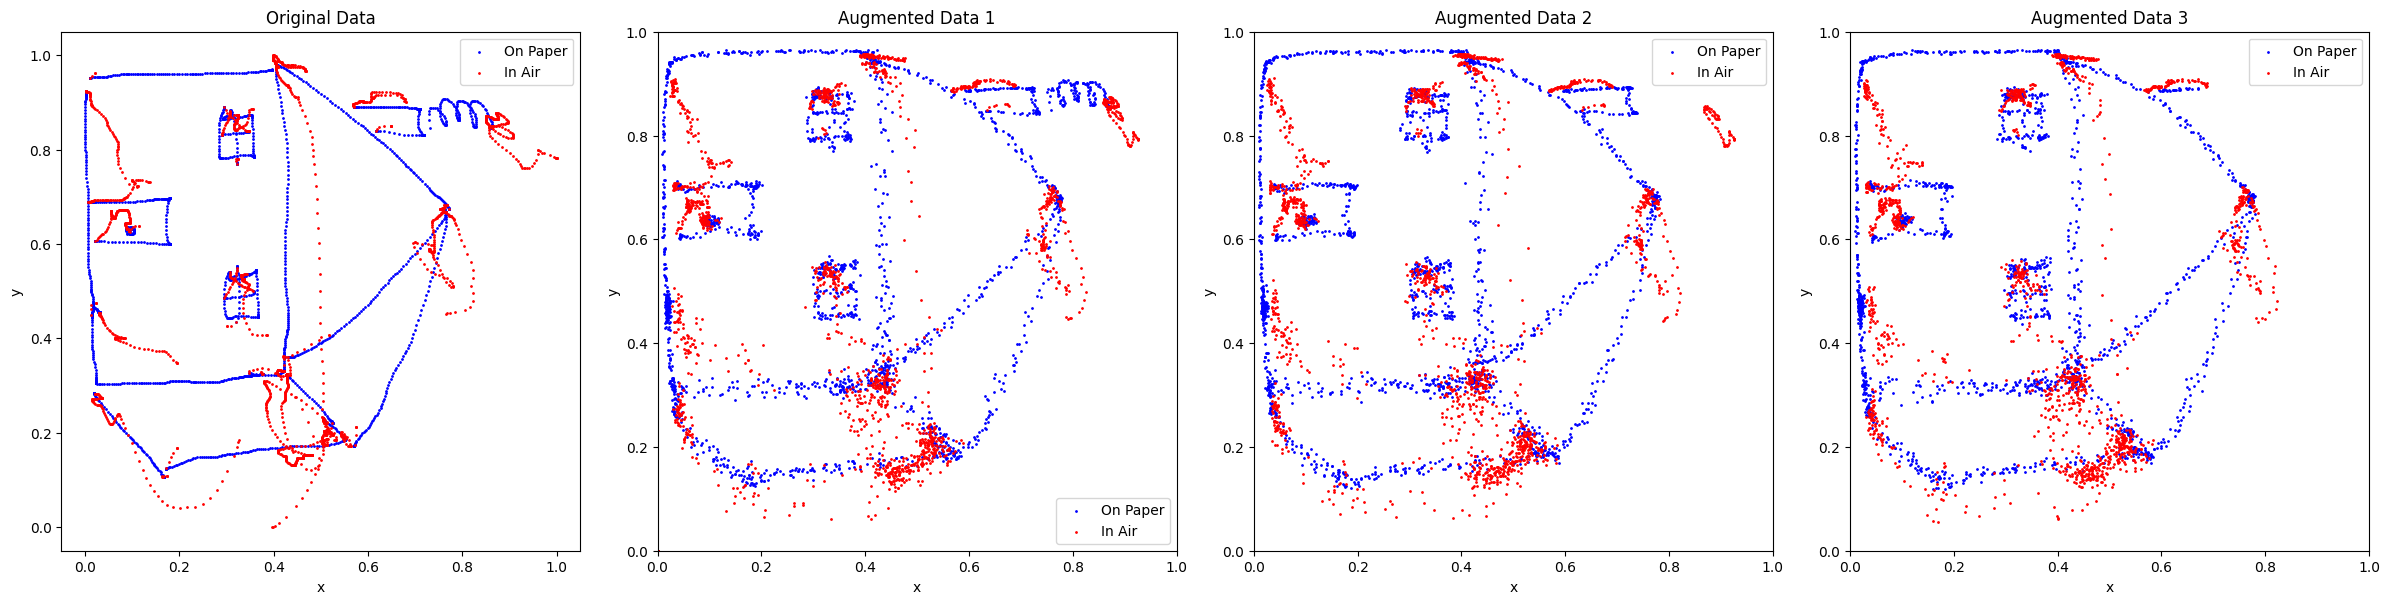

In [25]:
# Cell 5 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of points
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

num_augmented_files = 3
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 3] == 1]
original_in_air = combined_data[combined_data[:, 3] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()

In [54]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv
Saved augmented_data\augmented_data_2.csv
Saved augmented_data\augmented_data_3.csv
